In [2]:
import sys
sys.path.append("/auto/homes/fav25/jax/")

import jax.numpy as np
# import autograd.numpy
# import numpy as np

from SC_IPFP.sde_solvers import solve_sde_RK
from SC_IPFP.utils import log_kde_pdf_per_point, silvermans_rule

from jax.config import config
from jax import jit, grad, random
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu, LogSoftmax, Tanh
import numpy.random as npr
import jax
from tqdm.notebook import tqdm



import itertools
from functools import partial
# np = jax.numpy
import matplotlib.pyplot as plt
# np = autograd.numpy

/auto/homes/fav25/jax/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [ ]:
# """

# import jax.numpy as np
# import numpy as onp
# import jax
# import pylab as pl
# from jax import jit
# from functools import partial

# key = jax.random.PRNGKey(0)
# # key = None
# onp.random.seed(0)


# @partial(jit, static_argnums=(0,1, 4))
# def inner_jit(alfa, beta, Y, ti, N, Dn, DWs, Wn, dt, theta):
#     N = int(N)
#     alfa_ = alfa
    
#     n_, D_, *_ = Y.shape

    
#     if theta is not None:
# #         alfa_ = lambda X,t: alfa(theta, X)
#         def alfa_(X,t):
#             T = t.repeat(n_).reshape(n_,1)
#             X = np.concatenate((X,T), axis=1)
#             return alfa(theta, X)
        
#     def inner_loop(n, Y):
#         t = ti[n]
#         a, b, DWn = alfa_(Y[:,n, :], t), beta(Y[:,n, :], t), DWs[:,n,:]
#         # print Y[n,:]
#         newY = (  
#             Y[:,n, :] + a * Dn + b * DWn * Wn + 
#             0.5 * ( beta(Y[:,n, :] + b * np.sqrt(Dn), t) - b ) * 
#             (DWn**2.0 - Dn) / np.sqrt(Dn)
#         )
        
#         Y = jax.ops.index_update(Y, jax.ops.index[:,n+1,:],  newY)
#         return Y
    
#     Y = jax.lax.fori_loop (0, N-1, inner_loop, Y)

#     return ti, Y


# # @jit
# def solve_sde_RK(alfa=None, beta=None, X0=None, dt=1.0, N=100, t0=0.0,
#                 key = key, theta=None):
#     """
#             Kloeden - Numerical Solution of stochastic differential
#             equations (Springer 1992)  page XXX.
#             Strong order 1.0 Runge Kutta scheme.
#             http://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_method_%28SDE%29
#             dX = a(X,t)*dt + b(X, t)*dW
#     Syntax:
#     ----------
#     solve_sde(alfa=None, beta=None, X0=None, dt=None, N=100, t0=0, DW=None)
#     Parameters:
#     ----------
#         alfa  : a  function with two arguments, the X state and the time
#                 defines the differential equation.
#         beta  : a  function with two arguments, the X state and the time
#                 defines the stochastic part of the SDE.
#         X0    : Initial conditions of the SDE. Mandatory for SDEs
#                 with variables > 1 (default: gaussian np.random)
#         dt    : The timestep of the solution
#                 (default: 1)
#         N     : The number of timesteps (defines the length of the timeseries)
#                 (default: 100)
#         t0    : The initial time of the solution
#                 (default: 0)
    
#     """
    
#     randn = onp.random.randn
# #     print(X0)
       
#     if alfa is None or beta is None:
#         raise ValueError("Error: SDE not defined.")
#     n, d, *_ = X0.shape
        
#     X0 = randn(*alfa(0, 0).shape) if X0 is None else np.array(X0)
#     DWs  = randn(n, N-1, d)  * np.sqrt(dt)
    
    
#     Y, ti = np.zeros((n, N, d)), np.arange(N)*dt + t0
#     Y = jax.ops.index_update(Y, jax.ops.index[:,0,:],  X0)
    
#     Dn, Wn = dt, 1
        
#     return inner_jit(alfa, beta, Y, ti, N, Dn, DWs, Wn, dt, theta)
# """

In [59]:
class cIPFP(object):
    
    def __init__(self, X_0, X_1, weights=[100], batch_size=None,  rng = jax.random.PRNGKey(0), 
                nrng = npr.RandomState(0), number_time_steps=16, sde_solver=solve_sde_RK, sigma_sq=1, 
                step_size = 0.001, num_epochs = 10, momentum_mass = 0.9, create_network=None):
        
        self.sde_solver = sde_solver
        
        self.number_time_steps = number_time_steps
        self.dt = 1.0 / number_time_steps
        
        
        self.batch_size_f = X_0.shape[0] if batch_size is None else batch_size
        self.batch_size_b = X_1.shape[0] if batch_size is None else batch_size
        
        
        self.X_0 = X_0
        self.X_1 = X_1
        
        self.H_0 = silvermans_rule(X_0)
        self.H_1 = silvermans_rule(X_1)
        
        _, self.dim = self.X_0.shape
        
        create_net = self.create_network if  create_network is None else create_network
        
        self.b_forward_init, self.b_forward = create_net(
            self.dim, weights
        )
        self.b_backward_init, self.b_backward = create_net(
            self.dim, weights
        )
        
        self.sigma = (lambda X,t: sigma_sq)
        
        self.rng = rng
        self.nrng = nrng
        
        self.opt_init_f, self.opt_update_f, self.get_params_f = (
            optimizers.adam(step_size) #, mass=momentum_mass)
        )
        
        self.opt_init_b, self.opt_update_b, self.get_params_b = (
            optimizers.adam(step_size) #, mass=momentum_mass)
        )
        
        num_complete_batches_f, leftover_f = divmod(self.X_0.shape[0], self.batch_size_f)
        self.num_batches_f = num_complete_batches_f + bool(leftover_f)
                                               
        num_complete_batches_b, leftover_b = divmod(self.X_1.shape[0], self.batch_size_b)
        self.num_batches_b = num_complete_batches_b + bool(leftover_b)
        
        self.theta_f = None
        self.theta_b = None
        
    
    @staticmethod
    def create_network(dim, weights):
        
        model  = []
        for weight in weights:
            model.append(
                Dense(weight)
            )
                        
            model.append(
                Relu
            )
            
        
        model.append(Dense(dim))
    
        init_random_params, predict = stax.serial(
           *model
        )
        return init_random_params, predict
        
    @partial(jit, static_argnums=(0,2,3, 6))
    def loss_for_trajectory(self, Xt, b_f, b_b, dt, theta, forwards):
        n_, *_ = Xt.shape
        
        if not forwards : Xt = Xt[: , ::-1, :]
        
        if forwards:
            b_minus  = b_b(self.theta_b, Xt)
            b_plus = b_f(theta, Xt)
        else:
            b_minus  = b_b(theta, Xt)
            b_plus = b_f(self.theta_f, Xt)
            
        delta_Xt = Xt[:, :-1, :]  - Xt[:, 1:, :]
        
        sign = 1.0 if forwards else -1.0
        
        ito_integral = sign *  (b_plus[:, 1:,:] - b_minus[:, :-1,:])  * delta_Xt
        
        time_integral = sign *  (b_plus**2 - b_minus**2) * dt # Not sure about this dt here
        
        return ito_integral.sum(axis=(1,2)) - 0.5 * time_integral.sum(axis=(1,2))
        
    def data_stream(self, forward=True):
        rng = self.nrng
        X = self.X_0 if forward else self.X_1
        
        batch_size = self.batch_size_f if forward else self.batch_size_b
        num_batches = self.num_batches_f if forward else self.num_batches_b
        
        num_train = self.X_0.shape[0] if forward else self.X_1.shape[0]
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield X[batch_idx] 
        
    @staticmethod
    def sample_trajectory(X, dt, theta, sigma, b, N, sde_solver, forwards=True):
        return sde_solver(alfa=b, beta=sigma,
                          dt=dt, X0=X,
                          N=N, theta=theta)

#     @partial(jit, static_argnums=(0,6,7,8,9,10,11))
    def inner_loss_jit(self, terminal_index, theta, batch, dt, 
                       batch_terminal_empirical, H , b_forward,
                       b_backward, sigma, N, sde_solver, forwards):
        
        b = (b_forward if forwards else (lambda X, theta: -b_backward(X, theta)))
        
        t, Xt = cIPFP.sample_trajectory(batch, dt, theta,  sigma, b, N, sde_solver, forwards)
        cross_entropy = -log_kde_pdf_per_point(Xt[:,-1,:], batch_terminal_empirical, H)
        main_term = self.loss_for_trajectory(Xt, b_forward, b_backward, dt, theta, forwards)

        J = np.mean(main_term + cross_entropy )
        J = np.squeeze(J)
        return J
    
#     @partial(jit, static_argnums=(0,2))
    def transport_batch(self, batch_x, forwards):
        theta = self.theta_f if forwards else self.theta_b    
        b = self.b_forward if forwards else  lambda X, theta: -self.b_backward(X, theta)

        t, Xt = self.sde_solver(
            alfa=b, beta=self.sigma, dt=self.dt, 
            X0=batch_x.reshape(-1,self.dim), N=self.number_time_steps, theta=theta
        )

        return Xt[:,-1,:]
    
    def inner_loss(self, theta, batch, forwards=True):
                       
        terminal_index = -1 if forwards else 0
        X_terminal_empirical = next(self.data_stream(forward=not(forwards)))
    
        H = self.H_1 if forwards else self.H_0
        return self.inner_loss_jit(
            terminal_index, theta, batch, self.dt, 
            X_terminal_empirical, H , self.b_forward,
            self.b_backward, self.sigma, self.number_time_steps, self.sde_solver, forwards
        )

    @partial(jit, static_argnums=(0,1, 4))
    def update(self, i, opt_state, batch, forwards=True):

        get_params = self.get_params_f if forwards else self.get_params_b
        params = get_params(opt_state)
        
        gradient = grad(self.inner_loss)(params, batch, forwards)
    
        opt_update  = self.opt_update_f if forwards else self.opt_update_b
        return opt_update(i, gradient, opt_state)

    def fit(self, IPFP_iterations=10, sub_iterations=10):     
        
        _, init_params_f = self.b_forward_init(self.rng, (-1, self.dim))                                             
        opt_state_f = self.opt_init_f(init_params_f)
        
        _, init_params_b = self.b_backward_init(self.rng, (-1, self.dim))                                               
        opt_state_b = self.opt_init_b(init_params_b)
        
        batches_f = self.data_stream(forward=True)
        batches_b = self.data_stream(forward=False)
        
        loss_f, loss_b = [], []
        
        self.theta_f = self.get_params_f(opt_state_f)
        self.theta_b = self.get_params_b(opt_state_b)
        
        for i in tqdm(range(IPFP_iterations)):
                                               
            itercount = itertools.count()
            
            for k in range(sub_iterations):
                for _ in range(self.num_batches_b):
#                     print(_)
                    batch_b =  next(batches_b)
                    opt_state_b  = self.update(
                        next(itercount), opt_state_b, batch_b, False
                    )

                params = self.get_params_b(opt_state_b)
                lossb = self.inner_loss(params, batch_b, False)
                print(f"loss b {lossb}")
            loss_b.append(lossb)
                                               
            self.theta_b = self.get_params_b(opt_state_b)
            
            itercount = itertools.count()
            
            for k in range(sub_iterations):
                for _ in range(self.num_batches_f):
#                     print(_)
                    batch_f =  next(batches_f)
                    opt_state_f = self.update(
                        next(itercount), opt_state_f, next(batches_f), True
                    )
                params = self.get_params_f(opt_state_f)
                lossf = self.inner_loss(params, batch_f, True)
                print(f"loss f {lossf}")
            loss_f.append(lossf)
        

            self.theta_f = self.get_params_f(opt_state_f)
            
        
        plt.plot(range(IPFP_iterations), loss_f, "g")
        plt.show()
        plt.plot(range(IPFP_iterations), loss_b, "b")
        plt.show()
            

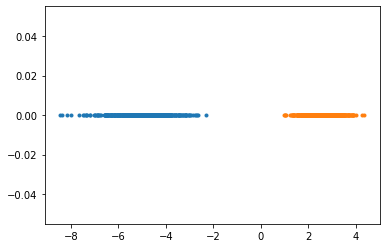

In [73]:
n = 500
n_2 = int(n * 0.5)

X1 = npr.randn(n).reshape(-1,1) - 5
X21 = 0.6 * npr.randn(n_2).reshape(-1,1) + 2.5
X22 =  0.6 * npr.randn(n_2).reshape(-1,1) + 2.5
X2 = np.concatenate((X21, X22), axis=0)


X1, X2 = X2, X1

plt.plot(X2.flatten(), [0] * n, '.')
plt.plot(X1.flatten(), [0] * n, '.')

In [74]:
c = cIPFP(X1, X2,  number_time_steps=100, batch_size=150 , step_size = 0.001, weights=[100])

In [41]:
 _, init_params_f = c.b_forward_init(c.rng, (-1, c.dim))                                             
opt_state_f = c.opt_init_f(init_params_f)


theta_f = c.get_params_f(opt_state_f)

In [34]:
theta_f[0][1].shape, theta_f[1]

((50,), ())

In [35]:
t, Xt = c.sample_trajectory(X1[0].reshape(-1,1),c.dt,  theta_f,  c.sigma, c.b_forward, c.number_time_steps, c.sde_solver, True)

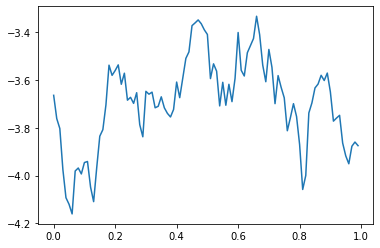

In [36]:
import matplotlib.pyplot as plt

plt.plot(t, Xt.flatten())

In [28]:
import numpy as onp
import jax.numpy as np

X0 = np.array(X1[0,:])
t0=0

alfa  = c.b_forward 
beta = c.sigma
randn = onp.random.randn
dt = c.dt
N= c.number_time_steps
theta = theta_f


if alfa is None or beta is None:
    raise ValueError("Error: SDE not defined.")


X0 = randn(*alfa(0, 0).shape) if X0 is None else np.array(X0)
#     DW = (lambda Y, dt: randn((len(X0))) * np.sqrt(dt)) if DW is None else DW
DWs  = randn(N-1, len(X0))  * np.sqrt(dt)



Y, ti = np.zeros((N, len(X0))), np.arange(N)*dt + t0
Y = jax.ops.index_update(Y, jax.ops.index[0,:],  X0)



In [29]:
loss= c.loss_for_trajectory(Xt, c.b_forward, c.b_backward, c.dt, theta_f, True)

In [101]:
cross_entropy = log_kde_pdf_per_point(Xt[-1].reshape(-1,1), X2, c.H_0)

In [102]:
%%time
c.inner_loss(theta_f, X1, True)

CPU times: user 742 ms, sys: 1.94 ms, total: 744 ms
Wall time: 711 ms


DeviceArray(137.47011, dtype=float32)

In [103]:
%%time
c.inner_loss(theta_f, X1, True)

CPU times: user 6.27 ms, sys: 6.8 ms, total: 13.1 ms
Wall time: 9.28 ms


DeviceArray(134.03041, dtype=float32)

In [294]:

# _, init_params_f = c.b_forward_init(c.rng, (-1, c.dim))                                             
# opt_state_f = c.opt_init_f(init_params_f)

# _, init_params_b = c.b_backward_init(c.rng, (-1, c.dim))                                               
# opt_state_b = c.opt_init_b(init_params_b)

# batches_f = c.data_stream(forward=True)
# batches_b = c.data_stream(forward=False)

# c.update(0, opt_state_b, next(batches_b), forwards=False)
                                       

In [295]:
from jax import grad


In [18]:
%%time
gradient = jit(grad(c.inner_loss), static_argnums=(2))
kek = gradient(theta_f, X1, True)
# partial(jit, static_argnums=(2))(gradient)

CPU times: user 2.81 s, sys: 25.1 ms, total: 2.84 s
Wall time: 3.39 s


In [55]:
%%time
kek = gradient(theta_f, X1, True)

loss b 3788.1796875
loss f 107.22417449951172



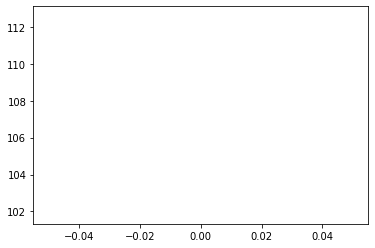

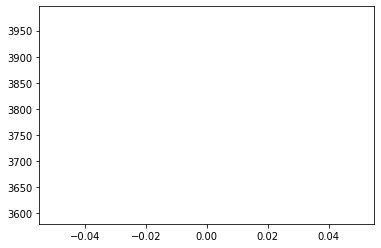

CPU times: user 50.3 s, sys: 491 ms, total: 50.8 s
Wall time: 48.9 s


In [104]:
%%time
c.fit(1,1)

loss b 3636.346435546875
loss f 108.60559844970703



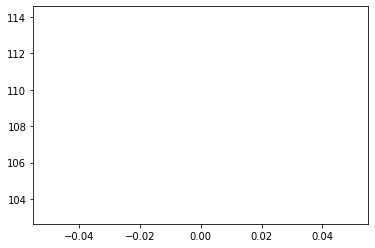

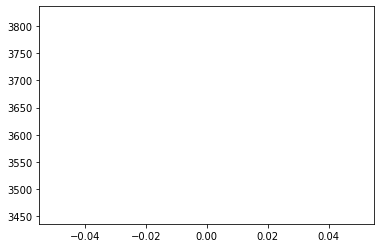

CPU times: user 2.98 s, sys: 1.14 s, total: 4.12 s
Wall time: 2.4 s


In [105]:
%%time
c.fit(1,1)

Widget Javascript not detected.  It may not be installed or enabled properly.


loss b 1093.1324462890625
loss f 300.11163330078125
loss b 962.18701171875
loss f 292.13232421875
loss b 832.3136596679688
loss f 303.18914794921875
loss b 696.6298217773438
loss f 237.9420928955078
loss b 619.0665893554688
loss f 257.94805908203125
loss b 565.1931762695312
loss f 228.8717498779297
loss b 514.286865234375
loss f 254.8042449951172
loss b 433.3345031738281
loss f 210.4436492919922
loss b 378.8555603027344
loss f 163.92185974121094
loss b 462.6162109375
loss f 179.65011596679688
loss b 324.86041259765625
loss f 206.43650817871094
loss b 373.6348571777344
loss f 147.39955139160156
loss b 318.6844787597656
loss f 161.896484375
loss b 322.9273376464844
loss f 161.0045928955078
loss b 344.8862609863281
loss f 151.58413696289062
loss b 320.7829284667969
loss f 110.68263244628906
loss b 289.49078369140625
loss f 137.57437133789062
loss b 198.0759735107422
loss f 138.639892578125
loss b 186.8620147705078
loss f 130.43682861328125
loss b 210.36329650878906
loss f 120.952697753906

loss b -150.24098205566406
loss f -147.84690856933594
loss b -149.9978485107422
loss f -145.09645080566406
loss b -157.6855926513672
loss f -178.99307250976562
loss b -158.1709442138672
loss f -162.64022827148438
loss b -151.69354248046875
loss f -175.05101013183594
loss b -156.63458251953125
loss f -168.7000274658203
loss b -153.55819702148438
loss f -197.4416046142578
loss b -153.48654174804688
loss f -187.068115234375
loss b -145.80517578125
loss f -137.00393676757812
loss b -152.63877868652344
loss f -175.2538299560547
loss b -150.7613983154297
loss f -104.7401123046875
loss b -161.58230590820312
loss f -154.73806762695312
loss b -165.9057159423828
loss f -136.94500732421875
loss b -154.9983673095703
loss f -184.26243591308594
loss b -153.0620574951172
loss f -185.68316650390625
loss b -152.95750427246094
loss f -151.6916961669922
loss b -158.57296752929688
loss f -154.15911865234375
loss b -170.16818237304688
loss f -204.0269775390625
loss b -162.0898895263672
loss f -102.24488830

loss b -314.815185546875
loss f -182.6302032470703
loss b -331.3500671386719
loss f -190.25457763671875
loss b -319.1011962890625
loss f -188.7254180908203
loss b -296.53045654296875
loss f -132.95440673828125
loss b -300.6634216308594
loss f -196.88795471191406
loss b -298.07086181640625
loss f -143.16171264648438
loss b -314.656005859375
loss f -190.68731689453125
loss b -330.89410400390625
loss f -196.08941650390625
loss b -319.4246826171875
loss f -199.751953125
loss b -325.6042785644531
loss f -153.26290893554688
loss b -317.7944641113281
loss f -193.3080596923828
loss b -303.6724548339844
loss f -97.73255920410156
loss b -335.8934326171875
loss f -187.9307098388672
loss b -315.7155456542969
loss f -176.8057403564453
loss b -342.8834228515625
loss f -150.1199493408203
loss b -339.7756042480469
loss f -186.8246612548828
loss b -341.32470703125
loss f -113.85201263427734
loss b -309.5747985839844
loss f -179.23287963867188
loss b -341.9169006347656
loss f -175.60926818847656
loss b 

loss b -589.0269775390625
loss f -155.60400390625
loss b -555.8414916992188
loss f -191.0052490234375
loss b -605.4105834960938
loss f -182.30296325683594
loss b -592.9165649414062
loss f -111.51055908203125
loss b -578.2399291992188
loss f -127.784423828125
loss b -614.532470703125
loss f -196.50704956054688
loss b -626.5778198242188
loss f -187.53665161132812
loss b -587.0428466796875
loss f -195.1754913330078
loss b -559.681396484375
loss f -151.12850952148438
loss b -570.5278930664062
loss f -144.81874084472656
loss b -623.1854248046875
loss f -159.5364227294922
loss b -587.4028930664062
loss f -130.11753845214844
loss b -599.0302734375
loss f -175.91041564941406
loss b -592.489013671875
loss f -183.49758911132812
loss b -590.63818359375
loss f -196.32469177246094
loss b -599.4334716796875
loss f -194.998779296875
loss b -605.5665283203125
loss f -175.11492919921875
loss b -651.7686767578125
loss f -164.44712829589844
loss b -632.115966796875
loss f -196.54562377929688
loss b -590.

loss b -921.2767944335938
loss f -177.5632781982422
loss b -877.3939819335938
loss f -176.27545166015625
loss b -920.5759887695312
loss f -124.71267700195312
loss b -888.7026977539062
loss f -108.49500274658203
loss b -933.1478271484375
loss f -177.1811981201172
loss b -888.3911743164062
loss f -188.20071411132812
loss b -903.0059814453125
loss f -137.22596740722656
loss b -989.7728271484375
loss f -204.77537536621094
loss b -942.2266845703125
loss f -143.14239501953125
loss b -961.0496826171875
loss f -151.43807983398438
loss b -907.3223876953125
loss f -189.7288818359375
loss b -937.8966064453125
loss f -182.67042541503906
loss b -905.5902099609375
loss f -201.4574432373047
loss b -912.6942138671875
loss f -197.20350646972656
loss b -933.2858276367188
loss f -170.12416076660156
loss b -940.25048828125
loss f -189.44000244140625
loss b -1027.6571044921875
loss f -200.94973754882812
loss b -975.3259887695312
loss f -192.09268188476562
loss b -927.240478515625
loss f -194.32305908203125

loss b -1354.930908203125
loss f -142.5841064453125
loss b -1326.28271484375
loss f -197.716552734375
loss b -1329.93017578125
loss f -186.8294677734375
loss b -1334.138427734375
loss f -205.72064208984375
loss b -1311.2808837890625
loss f -186.6405487060547
loss b -1386.6953125
loss f -152.9265594482422
loss b -1299.2127685546875
loss f -188.3693084716797
loss b -1329.364013671875
loss f -203.1571044921875
loss b -1244.2606201171875
loss f -203.04104614257812
loss b -1249.910400390625
loss f -199.28773498535156
loss b -1280.7117919921875
loss f -193.14573669433594
loss b -1289.081298828125
loss f -190.72769165039062
loss b -1283.3221435546875
loss f -182.3144989013672
loss b -1404.658203125
loss f -211.7257080078125
loss b -1435.6875
loss f -145.8896484375
loss b -1339.6568603515625
loss f -146.86508178710938
loss b -1375.229736328125
loss f -197.8824462890625
loss b -1397.2099609375
loss f -188.43580627441406
loss b -1358.550048828125
loss f -202.50057983398438
loss b -1403.452514648

loss b -1649.7257080078125
loss f -200.53244018554688
loss b -1636.3206787109375
loss f -220.75953674316406
loss b -1658.21630859375
loss f -217.7032928466797
loss b -1719.877197265625
loss f -225.9643096923828
loss b -1699.2161865234375
loss f -212.03456115722656
loss b -1762.380859375
loss f -199.8614501953125
loss b -1722.92919921875
loss f -224.33653259277344
loss b -1654.375244140625
loss f -214.3423614501953
loss b -1634.6805419921875
loss f -215.24307250976562
loss b -1719.495361328125
loss f -221.43539428710938
loss b -1703.38037109375
loss f -214.57693481445312
loss b -1698.382568359375
loss f -188.9933624267578
loss b -1727.234375
loss f -223.90597534179688
loss b -1708.1407470703125
loss f -218.7017822265625
loss b -1832.531005859375
loss f -213.95645141601562
loss b -1610.71875
loss f -181.2372283935547
loss b -1732.5416259765625
loss f -226.30215454101562
loss b -1726.482421875
loss f -179.43215942382812
loss b -1654.8492431640625
loss f -216.68186950683594
loss b -1562.23

loss b -2131.5126953125
loss f -295.4581298828125
loss b -1873.7158203125
loss f -291.9296875
loss b -2124.758544921875
loss f -283.1278381347656
loss b -2025.5999755859375
loss f -299.86212158203125
loss b -1938.0340576171875
loss f -305.5991516113281
loss b -1899.572021484375
loss f -294.5884094238281
loss b -2041.008544921875
loss f -292.2945556640625
loss b -2011.4940185546875
loss f -277.9449462890625
loss b -2128.622802734375
loss f -287.85308837890625
loss b -2098.611083984375
loss f -290.2418518066406
loss b -2083.894775390625
loss f -255.17652893066406
loss b -1911.1451416015625
loss f -298.5906982421875
loss b -1979.08837890625
loss f -249.0536651611328
loss b -2075.98681640625
loss f -284.1618347167969
loss b -2068.9267578125
loss f -296.8219909667969
loss b -2015.9068603515625
loss f -305.15435791015625
loss b -2164.689208984375
loss f -271.1060791015625
loss b -2155.143310546875
loss f -305.49957275390625
loss b -2234.55419921875
loss f -305.34564208984375
loss b -2045.364

loss b -2266.29345703125
loss f -391.24346923828125
loss b -2302.289794921875
loss f -398.6368103027344
loss b -2324.1015625
loss f -420.63323974609375
loss b -2417.34423828125
loss f -414.58795166015625
loss b -2228.35595703125
loss f -410.2269287109375
loss b -2194.81396484375
loss f -414.3338317871094
loss b -2309.111328125
loss f -402.22772216796875
loss b -2180.552734375
loss f -420.7507019042969
loss b -2299.5859375
loss f -424.623779296875
loss b -2083.904052734375
loss f -430.63458251953125
loss b -2179.729248046875
loss f -405.7244567871094
loss b -2360.878173828125
loss f -410.6723937988281
loss b -2304.7373046875
loss f -428.0823974609375
loss b -2314.09716796875
loss f -372.87164306640625
loss b -2202.94970703125
loss f -355.3177185058594
loss b -2117.421875
loss f -413.35491943359375
loss b -2256.132568359375
loss f -385.44781494140625
loss b -2388.279541015625
loss f -399.5047607421875
loss b -2331.232421875
loss f -435.1459045410156
loss b -2188.3515625
loss f -395.81240

loss b -2440.020751953125
loss f -531.39697265625
loss b -2462.41259765625
loss f -517.232421875
loss b -2577.888916015625
loss f -548.3311767578125
loss b -2434.97705078125
loss f -536.0608520507812
loss b -2431.0771484375
loss f -546.8367309570312
loss b -2614.656005859375
loss f -542.2327270507812
loss b -2485.859375
loss f -560.22119140625
loss b -2315.32666015625
loss f -487.4874572753906
loss b -2370.54931640625
loss f -532.6070556640625
loss b -2446.26171875
loss f -505.4840393066406
loss b -2515.799560546875
loss f -539.4653930664062
loss b -2454.350830078125
loss f -547.64404296875
loss b -2480.19921875
loss f -541.3123779296875
loss b -2512.850341796875
loss f -528.84228515625
loss b -2474.02197265625
loss f -541.4165649414062
loss b -2575.018310546875
loss f -543.6666870117188
loss b -2491.996337890625
loss f -572.1188354492188
loss b -2325.822998046875
loss f -515.356201171875
loss b -2508.9580078125
loss f -551.6961669921875
loss b -2402.033203125
loss f -559.03515625
loss

loss b -2986.786376953125
loss f -677.0892333984375
loss b -2788.823486328125
loss f -676.0730590820312
loss b -2898.6162109375
loss f -656.9241943359375
loss b -2893.810791015625
loss f -686.4255981445312
loss b -2867.5595703125
loss f -677.3458862304688
loss b -2812.353515625
loss f -652.42578125
loss b -2862.611328125
loss f -630.718505859375
loss b -2860.551513671875
loss f -677.15673828125
loss b -2883.71533203125
loss f -674.8540649414062
loss b -2703.198486328125
loss f -655.4091186523438
loss b -2903.349365234375
loss f -656.94921875
loss b -2808.8359375
loss f -685.0211181640625
loss b -2718.2255859375
loss f -687.2098388671875
loss b -2959.25830078125
loss f -713.4756469726562
loss b -3072.693115234375
loss f -655.0728149414062
loss b -2785.704345703125
loss f -702.8203735351562
loss b -2862.090087890625
loss f -701.0736694335938
loss b -2804.397705078125
loss f -680.0927734375
loss b -2718.46044921875
loss f -699.3283081054688
loss b -2883.281494140625
loss f -719.1510009765

loss b -3185.98876953125
loss f -808.9276733398438
loss b -3290.240234375
loss f -827.217529296875
loss b -3158.680908203125
loss f -842.3124389648438
loss b -3331.8291015625
loss f -835.5830078125
loss b -3438.789306640625
loss f -841.0982055664062
loss b -3219.39453125
loss f -826.9755859375
loss b -3210.6396484375
loss f -853.4661254882812
loss b -3481.150390625
loss f -831.12060546875
loss b -3416.196044921875
loss f -821.0629272460938
loss b -3330.805419921875
loss f -824.9494018554688
loss b -3429.1533203125
loss f -816.8472900390625
loss b -3270.1484375
loss f -846.4686889648438
loss b -3356.718505859375
loss f -861.0678100585938
loss b -3421.384521484375
loss f -869.6618041992188
loss b -3306.103515625
loss f -840.3217163085938
loss b -3371.83349609375
loss f -804.636962890625
loss b -3513.669677734375
loss f -803.4811401367188
loss b -3365.35205078125
loss f -851.8465576171875
loss b -3387.66796875
loss f -820.0407104492188
loss b -3343.749267578125
loss f -820.7341918945312
l

loss b -3753.081298828125
loss f -1045.4542236328125
loss b -3759.756103515625
loss f -1042.8675537109375
loss b -3970.39404296875
loss f -1052.3651123046875
loss b -3886.7275390625
loss f -1051.82958984375
loss b -3848.05029296875
loss f -1016.6533203125
loss b -3737.288818359375
loss f -1051.65771484375
loss b -3813.947265625
loss f -1082.661376953125
loss b -3924.8955078125
loss f -1061.0386962890625
loss b -3916.173095703125
loss f -1029.8427734375
loss b -3790.762451171875
loss f -1061.945556640625
loss b -3922.24755859375
loss f -1046.503662109375
loss b -3809.95068359375
loss f -1024.5301513671875
loss b -3709.552490234375
loss f -1053.549560546875
loss b -3944.642822265625
loss f -1058.7633056640625
loss b -3826.172119140625
loss f -1081.956298828125
loss b -3833.93115234375
loss f -1048.704345703125
loss b -3807.4736328125
loss f -1022.468994140625
loss b -4008.0458984375
loss f -1092.36572265625
loss b -4011.08447265625
loss f -1076.4930419921875
loss b -3893.06640625
loss f 

loss b -4489.9814453125
loss f -1372.4886474609375
loss b -4678.73388671875
loss f -1370.1151123046875
loss b -4390.73095703125
loss f -1378.3487548828125
loss b -4529.70068359375
loss f -1337.380126953125
loss b -4511.72900390625
loss f -1368.2437744140625
loss b -4541.2158203125
loss f -1379.48779296875
loss b -4677.95556640625
loss f -1347.7882080078125
loss b -4619.7275390625
loss f -1401.2640380859375
loss b -4348.09375
loss f -1297.43115234375
loss b -4472.41015625
loss f -1378.5767822265625
loss b -4734.98193359375
loss f -1373.107177734375
loss b -4384.513671875
loss f -1397.969970703125
loss b -4572.4384765625
loss f -1376.29833984375
loss b -4466.912109375
loss f -1373.6126708984375
loss b -4688.15380859375
loss f -1340.6744384765625
loss b -4441.52783203125
loss f -1369.51025390625
loss b -4628.16943359375
loss f -1401.78369140625
loss b -4733.58349609375
loss f -1410.7889404296875
loss b -4699.38427734375
loss f -1331.0771484375
loss b -4685.75927734375
loss f -1375.3463134

loss b -5188.7509765625
loss f -1902.0206298828125
loss b -5491.29248046875
loss f -1880.9610595703125
loss b -5402.05419921875
loss f -1950.7130126953125
loss b -5269.923828125
loss f -1905.666015625
loss b -5573.05419921875
loss f -1810.2532958984375
loss b -5395.0322265625
loss f -1815.264404296875
loss b -5310.318359375
loss f -1943.26220703125
loss b -5304.8984375
loss f -1950.31640625
loss b -5454.15673828125
loss f -1959.3765869140625
loss b -5488.83935546875
loss f -1883.0635986328125
loss b -5498.01513671875
loss f -1926.57373046875
loss b -5598.69921875
loss f -1899.9322509765625
loss b -5335.71728515625
loss f -1972.0001220703125
loss b -5593.97021484375
loss f -1904.939208984375
loss b -5578.45654296875
loss f -1976.7720947265625
loss b -5656.74951171875
loss f -1977.244140625
loss b -5539.85205078125
loss f -1900.81689453125
loss b -5611.0234375
loss f -2001.8546142578125
loss b -5414.7783203125
loss f -1975.2862548828125
loss b -5602.80078125
loss f -1989.048828125
loss b

loss b -6529.56884765625
loss f -2831.55615234375
loss b -6662.18701171875
loss f -2770.52197265625
loss b -6319.2744140625
loss f -2930.861083984375
loss b -6483.73095703125
loss f -2931.505126953125
loss b -6620.2431640625
loss f -2866.097900390625
loss b -6518.55859375
loss f -2916.393798828125
loss b -6328.9765625
loss f -2924.62841796875
loss b -6580.94140625
loss f -2815.778564453125
loss b -6336.384765625
loss f -2951.4208984375
loss b -6494.55322265625
loss f -2792.993896484375
loss b -6579.0322265625
loss f -2922.5234375
loss b -6515.92578125
loss f -2961.185546875
loss b -6652.59423828125
loss f -2850.232421875
loss b -6716.9990234375
loss f -2956.65576171875
loss b -6622.818359375
loss f -2990.935791015625
loss b -6733.99365234375
loss f -3014.100341796875
loss b -6876.00341796875
loss f -3035.389892578125
loss b -6846.12060546875
loss f -2991.068359375
loss b -6722.71826171875
loss f -2999.386962890625
loss b -6611.32177734375
loss f -2859.29541015625
loss b -6547.4921875
l

loss b -7985.99853515625
loss f -4252.54345703125
loss b -7861.044921875
loss f -4302.6884765625
loss b -7815.2841796875
loss f -4381.85302734375
loss b -8121.755859375
loss f -4361.44775390625
loss b -7923.6943359375
loss f -4147.609375
loss b -8017.583984375
loss f -4126.69677734375
loss b -7811.0126953125
loss f -4369.69384765625
loss b -8250.4013671875
loss f -4274.75341796875
loss b -7870.958984375
loss f -4479.07275390625
loss b -8073.94580078125
loss f -4204.5341796875
loss b -7923.09912109375
loss f -4218.41015625
loss b -7828.17578125
loss f -4457.392578125
loss b -7950.07666015625
loss f -4389.744140625
loss b -7737.58251953125
loss f -4380.96875
loss b -8155.5625
loss f -4460.4345703125
loss b -7957.32861328125
loss f -4431.3740234375
loss b -7601.109375
loss f -4272.80908203125
loss b -8107.52001953125
loss f -4532.603515625
loss b -8225.2998046875
loss f -4522.421875
loss b -8095.71337890625
loss f -4555.015625
loss b -8219.970703125
loss f -4526.521484375
loss b -7704.110

loss b -9626.962890625
loss f -6233.56103515625
loss b -9430.1611328125
loss f -6313.2373046875
loss b -9334.666015625
loss f -6314.58056640625
loss b -9396.6181640625
loss f -6325.52587890625
loss b -9327.4970703125
loss f -6400.494140625
loss b -9233.8046875
loss f -6400.73095703125
loss b -9378.3388671875
loss f -6243.9248046875
loss b -9504.6142578125
loss f -6432.8994140625
loss b -9858.4541015625
loss f -6311.31005859375
loss b -9334.04296875
loss f -6427.64111328125
loss b -9287.40625
loss f -6349.65380859375
loss b -9826.087890625
loss f -6416.1171875
loss b -9641.56640625
loss f -6194.0087890625
loss b -9345.3037109375
loss f -6482.1904296875
loss b -9750.083984375
loss f -6364.3291015625
loss b -9691.21875
loss f -6214.8515625
loss b -9768.9267578125
loss f -6506.1220703125
loss b -9548.953125
loss f -6491.77392578125
loss b -9670.7763671875
loss f -6588.85498046875
loss b -9627.8818359375
loss f -6401.12939453125
loss b -9761.005859375
loss f -6300.4970703125
loss b -9745.66

loss b -11014.451171875
loss f -8223.849609375
loss b -11067.197265625
loss f -8599.2734375
loss b -10811.9609375
loss f -8338.8984375
loss b -11248.0361328125
loss f -8687.32421875
loss b -10980.958984375
loss f -8645.0263671875
loss b -10836.5546875
loss f -8707.5771484375
loss b -11057.8193359375
loss f -8341.28515625
loss b -10985.6630859375
loss f -8687.6318359375
loss b -11057.0537109375
loss f -8670.0693359375
loss b -11186.3779296875
loss f -8581.416015625
loss b -10913.001953125
loss f -8755.259765625
loss b -11037.9619140625
loss f -8243.7734375
loss b -10979.162109375
loss f -8771.5556640625
loss b -11259.9599609375
loss f -8736.166015625
loss b -11306.4140625
loss f -8783.16015625
loss b -11548.4560546875
loss f -8780.5009765625
loss b -11419.9013671875
loss f -8852.162109375
loss b -10646.4267578125
loss f -8821.005859375
loss b -11108.7236328125
loss f -8816.10546875
loss b -10890.96484375
loss f -8764.8798828125
loss b -11182.8896484375
loss f -8894.8916015625
loss b -11

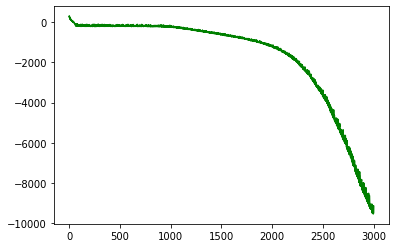

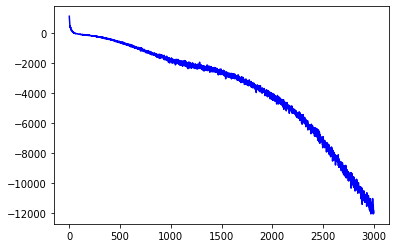

In [77]:
c.fit(3000,1)

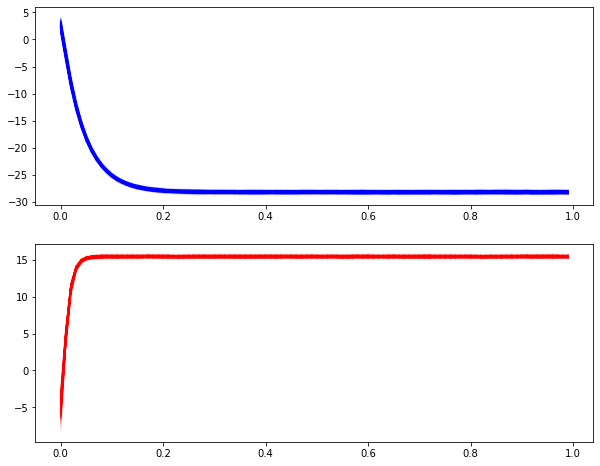

In [79]:
fig, axs = plt.subplots(2,1,  sharey=False, figsize=(10,8))


bb = lambda X, theta: -c.b_backward(X, theta)
t, Xts = c.sample_trajectory(X1,c.dt,  c.theta_f,  c.sigma, c.b_forward, c.number_time_steps, c.sde_solver)
for i in range(n):
    
    axs[0].plot(t.flatten(), Xts[i,...].flatten(), 'b', alpha=0.03, )
BXt = []   

t_, Xts_ = c.sample_trajectory(X2,c.dt,  c.theta_b,  c.sigma, bb, c.number_time_steps, c.sde_solver)
for i in range(n):
    
#     BXt.append(Xt_[-1,:])
    axs[1].plot(t_.flatten(), Xts_[i,...].flatten(), 'r', alpha=0.03)

In [60]:
# # @partial(jit, static_argnums=(0,2))
# npr.seed(0)
# def transport_batch(self, batch_x, forwards):
#     theta = self.theta_f if forwards else self.theta_b    
#     b = self.b_forward if forwards else  lambda X, theta: -self.b_backward(X, theta)

#     def inner_loss_loop_23(x_):
#         t, Xt = solve_sde_RK(alfa=b, beta=self.sigma, dt=self.dt, X0=x_.reshape(-1,1), N=number_time_steps, theta=theta)
#         return Xt[:,-1,:]

#     return inner_loss_loop_23(batch_x)

In [61]:
X22 = np.array(c.transport_batch( X1, True)).flatten()

In [62]:
X11 = np.array(c.transport_batch(X2, False)).flatten()

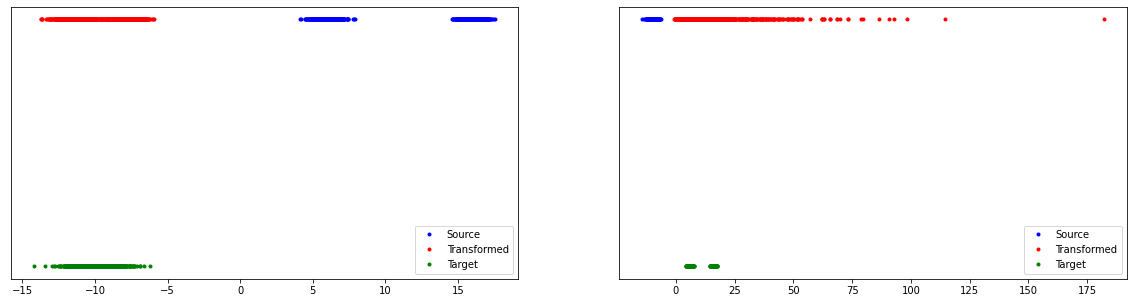

In [63]:
fig, axs = plt.subplots(1,2, figsize=(20,5))

axs[0].plot(X2.flatten(), [0] * n, 'b.', label="Source")
axs[0].plot(X11, [0] * n, 'r.', label="Transformed")
axs[0].plot(X1.flatten(), [-0.1] * n, 'g.', label="Target")
# axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].legend()

axs[1].plot(X1.flatten(), [0] * n, 'b.', label="Source")
axs[1].plot(X22, [0] * n, 'r.', label="Transformed")
axs[1].plot(X2.flatten(), [-0.1] * n, 'g.', label="Target")
# axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].legend()

In [604]:
batch_terminal_empirical_f = next(c.data_stream(forward=True))

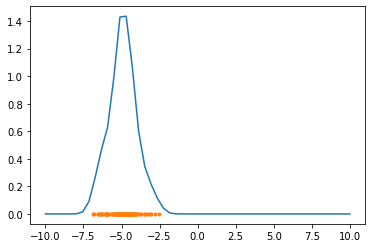

In [418]:
xx = np.linspace(-10, 10).reshape(-1,1)

kd  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_f, c.H_0))
plt.plot(xx, kd)
plt.plot(batch_terminal_empirical_f , [0] * len(batch_terminal_empirical_f), ".")

In [419]:
batch_terminal_empirical_b = next(c.data_stream(False))

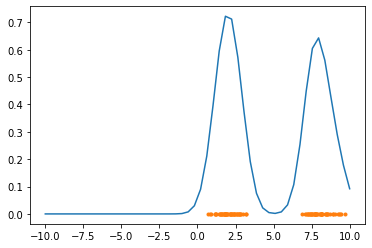

In [420]:
xx = np.linspace(-10, 10).reshape(-1,1)

kd_b  = np.exp(log_kde_pdf_per_point(xx, batch_terminal_empirical_b, c.H_1))
plt.plot(xx, kd_b)
plt.plot(batch_terminal_empirical_b , [0] * len(batch_terminal_empirical_b), ".")